# New York City Taxi Fare Prediction

<img src="images/taxi.jpg">

## Description

In this playground competition, hosted in partnership with Google Cloud and Coursera, you are tasked with predicting the fare amount (inclusive of tolls) for a taxi ride in New York City given the pickup and dropoff locations. While you can get a basic estimate based on just the distance between the two points, this will result in an RMSE of $5-$8, depending on the model used (see the starter code for an example of this approach in Kernels). Your challenge is to do better than this using Machine Learning techniques!

To learn how to handle large datasets with ease and solve this problem using TensorFlow, consider taking the Machine Learning with TensorFlow on Google Cloud Platform specialization on Coursera -- the taxi fare problem is one of several real-world problems that are used as case studies in the series of courses. To make this easier, head to Coursera.org/NEXTextended to claim this specialization for free for the first month!

## Dataset Description
### File descriptions

* **train.csv** - Input features and target fare_amount values for the training set (about 55M rows).
* **test.csv** - Input features for the test set (about 10K rows). Your goal is to predict fare_amount for each row.
* **sample_submission.csv** - a sample submission file in the correct format (columns key and fare_amount). This file 'predicts' * fare_amount to be $11.35 for all rows, which is the mean fare_amount from the training set.

## Data fields
### ID

* **key** - Unique string identifying each row in both the training and test sets. Comprised of pickup_datetime plus a unique integer, but this doesn't matter, it should just be used as a unique ID field.
Required in your submission CSV. Not necessarily needed in the training set, but could be useful to simulate a 'submission file' while doing cross-validation within the training set.

### Features

* **pickup_datetime** - timestamp value indicating when the taxi ride started.
* **pickup_longitude** - float for longitude coordinate of where the taxi ride started.
* **pickup_latitude** - float for latitude coordinate of where the taxi ride started.
* **dropoff_longitude** - float for longitude coordinate of where the taxi ride ended.
* **dropoff_latitude** - float for latitude coordinate of where the taxi ride ended.
* **passenger_count** - integer indicating the number of passengers in the taxi ride.

### Target

* **fare_amount** - float dollar amount of the cost of the taxi ride. This value is only in the training set; this is what you are predicting in the test set and it is required in your submission CSV.


In [85]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px 

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_column', 100)

In [86]:
df_train = pd.read_csv('data/train.csv', nrows = 2000000, parse_dates=["pickup_datetime"])
df_test = pd.read_csv('data/test.csv')

## EDA - Exploratory Data Analysis

In [87]:
df_train.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21+00:00,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16+00:00,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00+00:00,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42+00:00,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00+00:00,-73.968095,40.768008,-73.956655,40.783762,1


In [88]:
print(df_train.shape)
print(df_test.shape)

(2000000, 8)
(9914, 7)


In [89]:
df_train.dtypes

key                               object
fare_amount                      float64
pickup_datetime      datetime64[ns, UTC]
pickup_longitude                 float64
pickup_latitude                  float64
dropoff_longitude                float64
dropoff_latitude                 float64
passenger_count                    int64
dtype: object

In [90]:
df_train.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,2.000000e+06,2.000000e+06,2.000000e+06,1.999986e+06,1.999986e+06,2.000000e+06
mean,1.134779e+01,-7.252321e+01,3.992963e+01,-7.252395e+01,3.992808e+01,1.684113e+00
std,9.852883e+00,1.286804e+01,7.983352e+00,1.277497e+01,1.032382e+01,1.314982e+00
min,-6.200000e+01,-3.377681e+03,-3.458665e+03,-3.383297e+03,-3.461541e+03,0.000000e+00
25%,6.000000e+00,-7.399208e+01,4.073491e+01,-7.399141e+01,4.073400e+01,1.000000e+00
50%,8.500000e+00,-7.398181e+01,4.075263e+01,-7.398016e+01,4.075312e+01,1.000000e+00
75%,1.250000e+01,-7.396713e+01,4.076710e+01,-7.396369e+01,4.076809e+01,2.000000e+00
max,1.273310e+03,2.856442e+03,2.621628e+03,3.414307e+03,3.345917e+03,2.080000e+02


In [91]:
print('Original size: %d' % len(df_train))
df_train = df_train[df_train.fare_amount>=0]
print('New size: %d' % len(df_train))

Original size: 2000000
New size: 1999923


In [92]:
df_train.isnull().sum()

key                   0
fare_amount           0
pickup_datetime       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude    14
dropoff_latitude     14
passenger_count       0
dtype: int64

In [93]:
print('Original size: %d' % len(df_train))
df_train = df_train.dropna(how = 'any', axis = 'rows')
print('New size: %d' % len(df_train))

Original size: 1999923
New size: 1999909


In [94]:
print('Original size: %d' % len(df_train))
df_train = df_train.drop(df_train[df_train['passenger_count']>6].index, axis = 'rows')
df_train = df_train.drop(df_train[df_train['passenger_count']<0].index, axis = 'rows')
print('New size: %d' % len(df_train))

Original size: 1999909
New size: 1999907


In [95]:
print('Original size: %d' % len(df_train))
df_train = df_train.drop(df_train[df_train['pickup_longitude']>180].index, axis = 'rows')
df_train = df_train.drop(df_train[df_train['pickup_longitude']<-180].index, axis = 'rows')
df_train = df_train.drop(df_train[df_train['pickup_latitude']>90].index, axis = 'rows')
df_train = df_train.drop(df_train[df_train['pickup_latitude']<-90].index, axis = 'rows')
df_train = df_train.drop(df_train[df_train['dropoff_longitude']>180].index, axis = 'rows')
df_train = df_train.drop(df_train[df_train['dropoff_longitude']<-180].index, axis = 'rows')
df_train = df_train.drop(df_train[df_train['dropoff_latitude']>90].index, axis = 'rows')
df_train = df_train.drop(df_train[df_train['dropoff_latitude']<-90].index, axis = 'rows')
print('New size: %d' % len(df_train))

Original size: 1999907
New size: 1999822


## Data Visualization

<Axes: xlabel='fare_amount'>

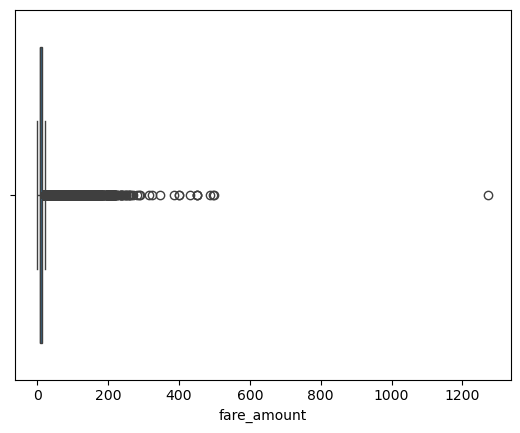

In [96]:
sns.boxplot(x=df_train['fare_amount'])

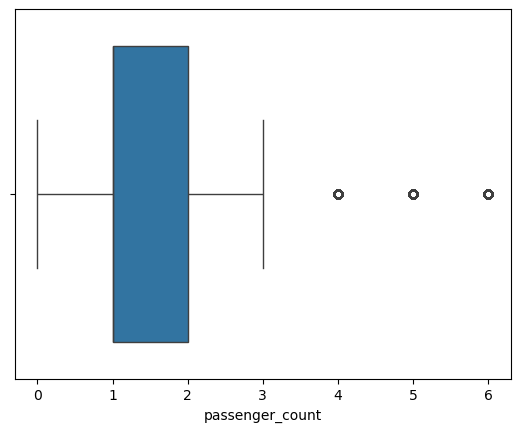

In [97]:
sns.boxplot(x=df_train['passenger_count']);

In [98]:
len(df_train[df_train.fare_amount < 100])/len(df_train)

0.9995719619046095

In [99]:
df_train = df_train[df_train.fare_amount < 100]
df_train = df_train[df_train.passenger_count < 50]

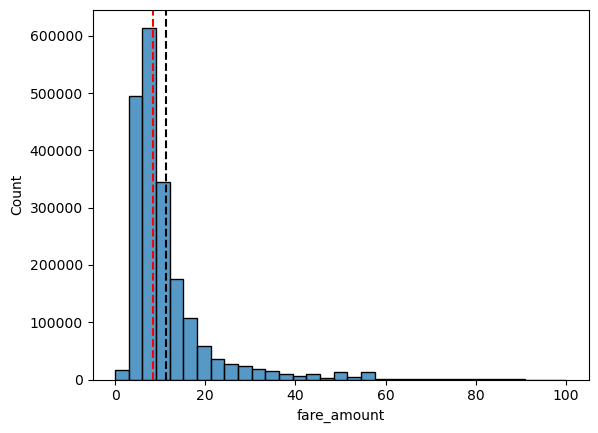

In [100]:
sns.histplot(data=df_train[df_train.fare_amount < 100], x="fare_amount", binwidth=3, bins=200)
plt.axvline(df_train["fare_amount"].mean(),color = "k",
            linestyle = "dashed",label = "Avg trip fare ($)")
plt.axvline(df_train["fare_amount"].median(),color = "r",
            linestyle = "dashed",label = "Median trip fare ($)");

In [101]:

year_col = df_train['pickup_datetime'].dt.year.to_frame()
year_col = year_col.rename(columns={"pickup_datetime":"Year"})
year_df = year_col.join(df_train["passenger_count"]).join(df_train["fare_amount"]).groupby('Year').sum().reset_index()
year_df.head()

,Year,passenger_count,fare_amount
0,2009,520864,3092664.37
1,2010,504938,3052196.82
2,2011,524812,3302916.29
3,2012,544040,3591182.58
4,2013,533942,3914752.97


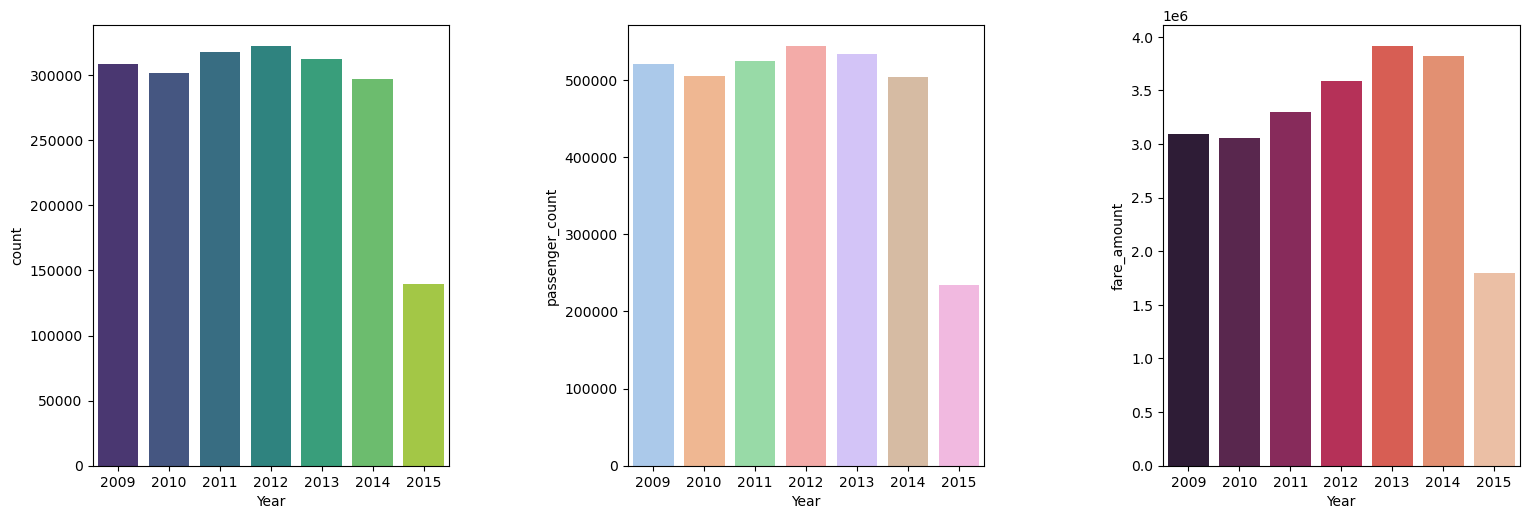

In [102]:
fig, axs = plt.subplots(ncols=3,figsize=(15, 5))
fig.tight_layout()
plt.subplots_adjust(wspace=0.5)
sns.countplot(data=year_col, x="Year", ax=axs[0], palette="viridis")
sns.barplot(data=year_df, x="Year", y="passenger_count", ax=axs[1], palette="pastel")
sns.barplot(data=year_df, x="Year", y="fare_amount", ax=axs[2], palette="rocket");

In [103]:
month_col = df_train['pickup_datetime'].dt.month.to_frame()
month_col = month_col.rename(columns={"pickup_datetime":"Month"})
month_df = month_col.join(df_train["passenger_count"]).join(df_train["fare_amount"]).groupby('Month').sum().reset_index()
month_df.head()

,Month,passenger_count,fare_amount
0,1,300000,1897502.09
1,2,281849,1834218.01
2,3,311991,2080156.96
3,4,308962,2074157.13
4,5,316695,2172396.21


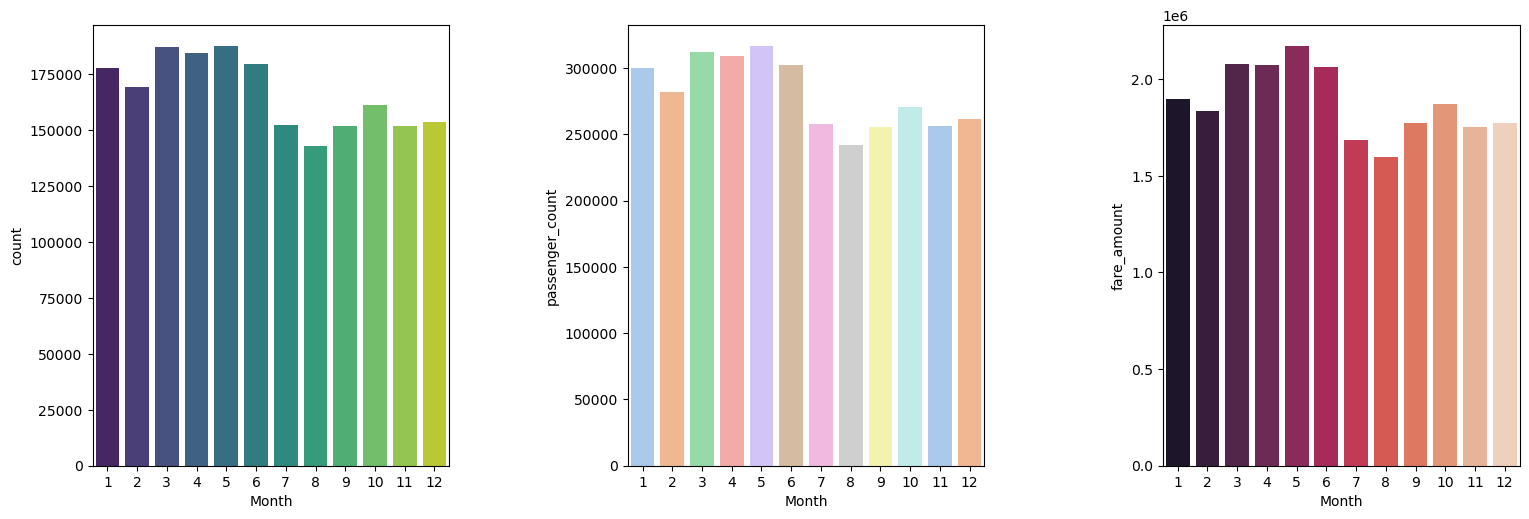

In [104]:
fig, axs = plt.subplots(ncols=3,figsize=(15, 5))
fig.tight_layout()
plt.subplots_adjust(wspace=0.5)
sns.countplot(data=month_col, x="Month", ax=axs[0], palette="viridis")
sns.barplot(data=month_df, x="Month", y="passenger_count", ax=axs[1], palette="pastel")
sns.barplot(data=month_df, x="Month", y="fare_amount", ax=axs[2], palette="rocket");

In [105]:
hour_col = df_train['pickup_datetime'].dt.hour.to_frame()
hour_col = hour_col.rename(columns={"pickup_datetime":"Hour"})
hour_df = hour_col.join(df_train["passenger_count"]).join(df_train["fare_amount"]).groupby('Hour').sum().reset_index()
hour_df.head()

,Hour,passenger_count,fare_amount
0,0,138626,919572.16
1,1,101937,665723.12
2,2,75624,495409.13
3,3,56236,380078.47
4,4,40270,314770.29


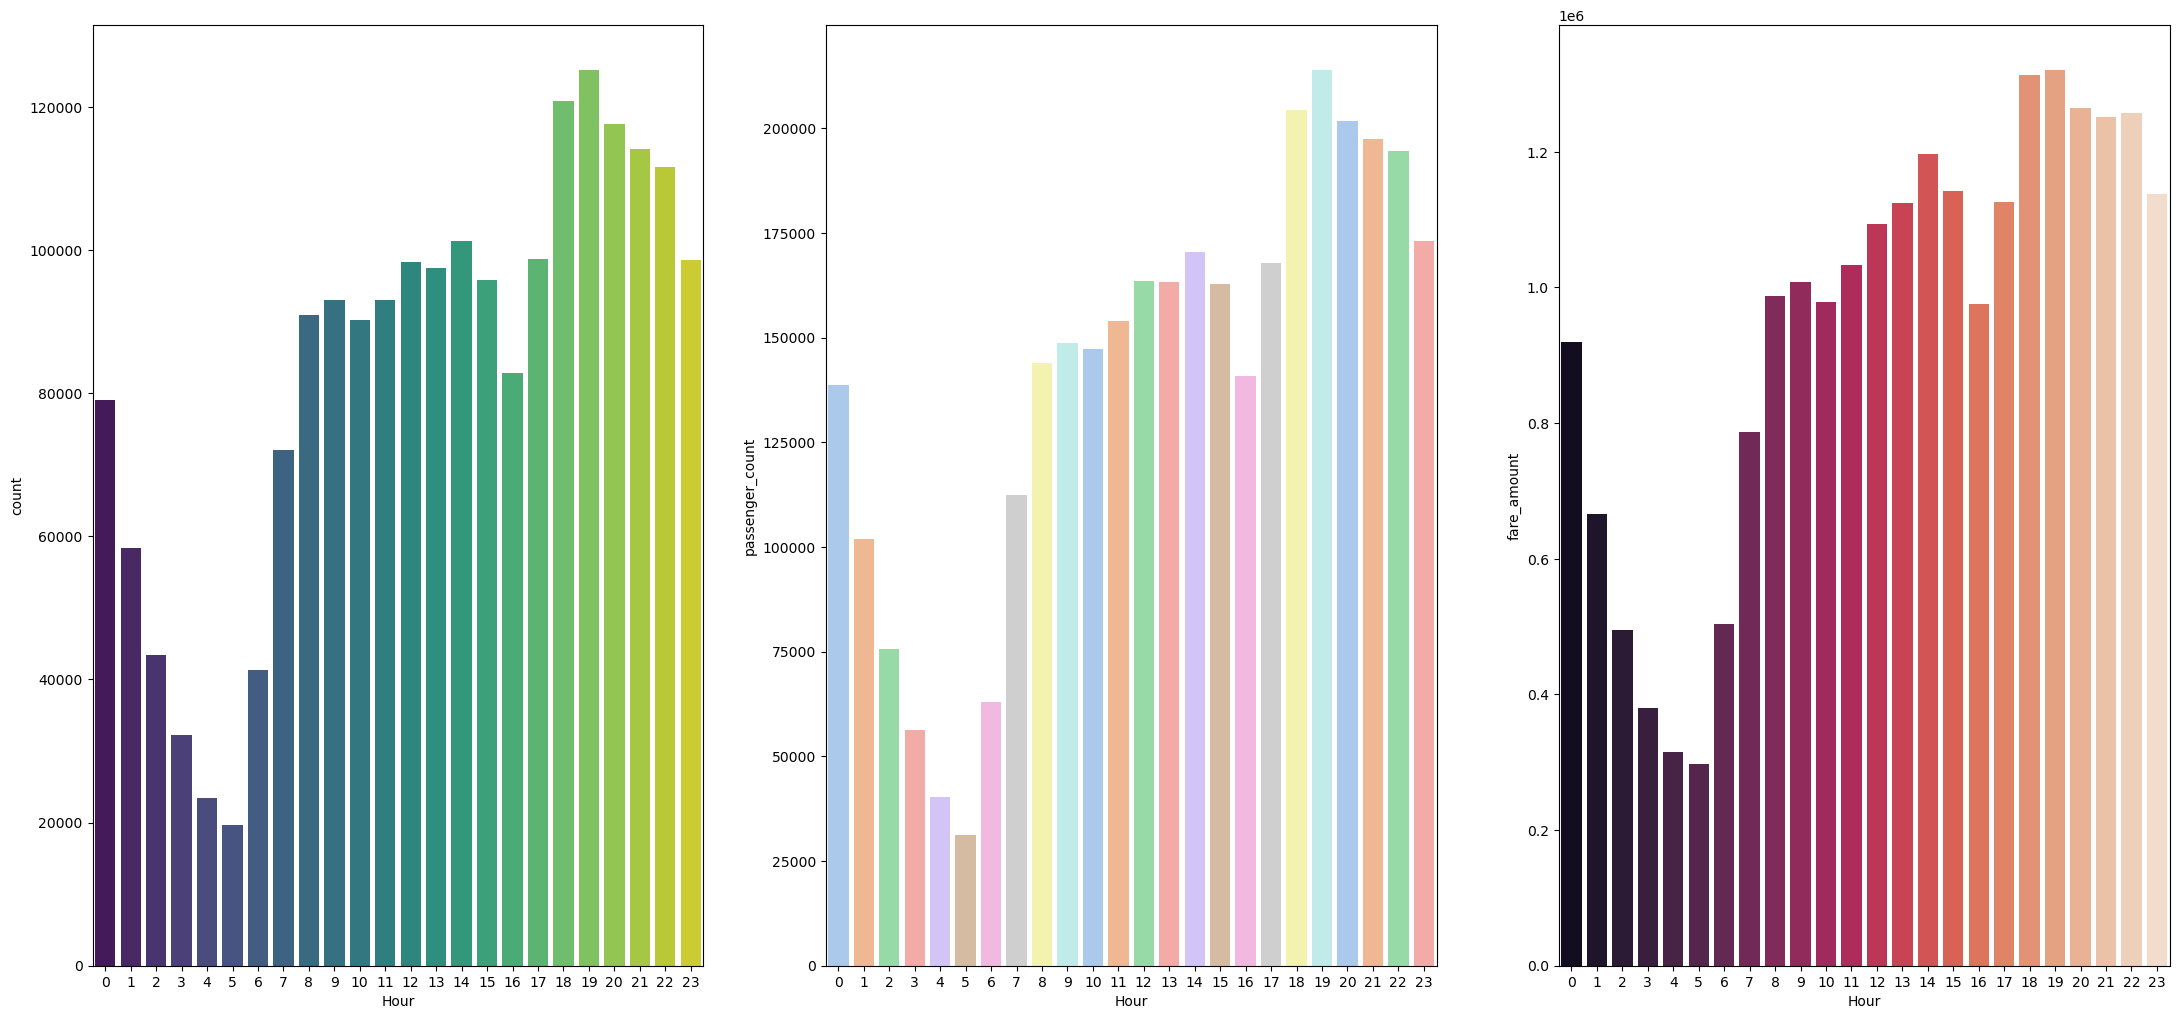

In [106]:
fig, axs = plt.subplots(ncols=3,figsize=(21.5, 10))
fig.tight_layout()
plt.subplots_adjust(wspace=0.2)
sns.countplot(data=hour_col, x="Hour", ax=axs[0], palette="viridis")
sns.barplot(data=hour_df, x="Hour", y="passenger_count", ax=axs[1], palette="pastel")
sns.barplot(data=hour_df, x="Hour", y="fare_amount", ax=axs[2], palette="rocket");

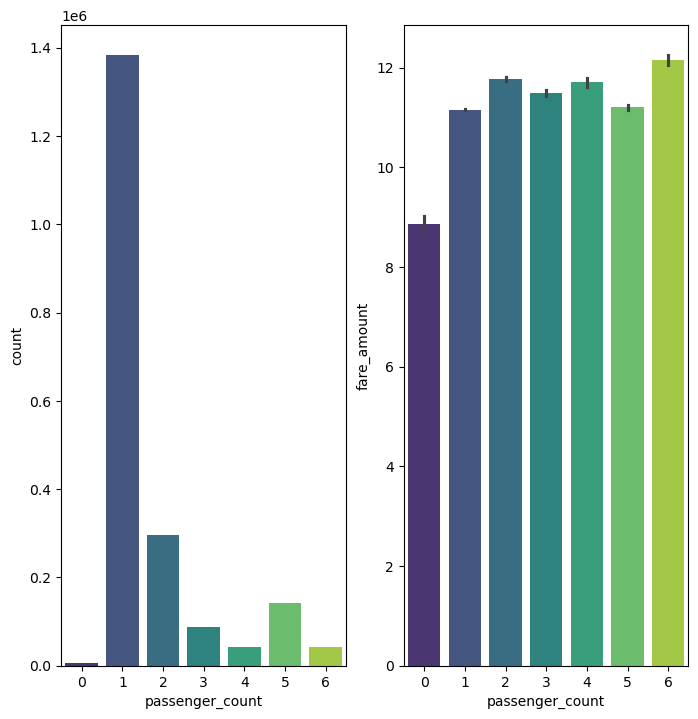

In [107]:
fig, axs = plt.subplots(ncols=2,figsize=(7, 7))
fig.tight_layout()
sns.countplot(data=df_train, x="passenger_count", ax=axs[0], palette="viridis")
sns.barplot(data=df_train, x=df_train['passenger_count'], y = df_train['fare_amount'], ax=axs[1], palette="viridis");

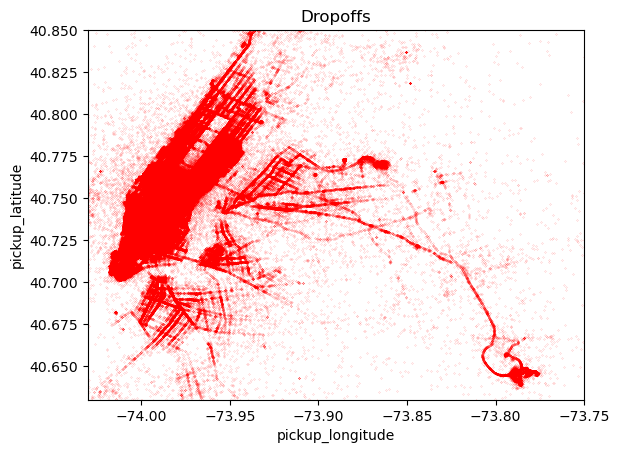

In [108]:
city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)

df_train.plot(kind='scatter', x='pickup_longitude', y='pickup_latitude',
                color='red', 
                s=.02, alpha=.6)
plt.title("Dropoffs")

plt.ylim(city_lat_border)
plt.xlim(city_long_border);

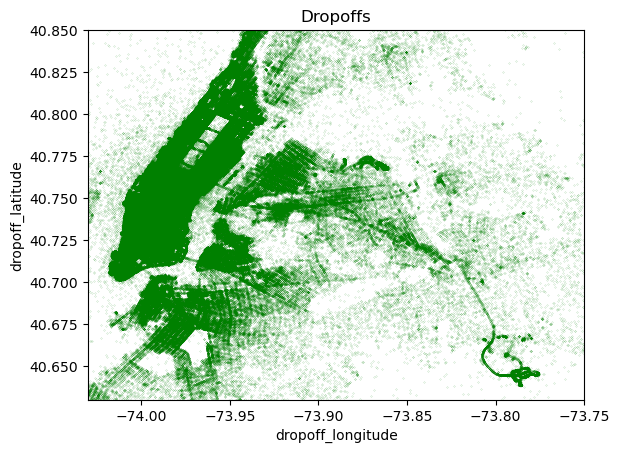

In [109]:
city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)

df_train.plot(kind='scatter', x='dropoff_longitude', y='dropoff_latitude',
                color='green', 
                s=.02, alpha=.6)
plt.title("Dropoffs")

plt.ylim(city_lat_border)
plt.xlim(city_long_border);

In [110]:
# !pip install haversine

In [111]:
import haversine as hs
df_train["loc1"] = df_train[["pickup_latitude","pickup_longitude"]].apply(tuple, axis=1)
df_train["loc2"] = df_train[["dropoff_latitude","dropoff_longitude"]].apply(tuple, axis=1)
df_train['H_Distance'] = df_train.apply(lambda row: hs.haversine(row.loc1,row.loc2), axis=1)
df_train.sample(10)

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,loc1,loc2,H_Distance
562817,2013-07-04 22:33:00.00000088,17.0,2013-07-04 22:33:00+00:00,-73.981847,40.773335,-73.944777,40.820757,1,"(40.773335, -73.981847)","(40.820757, -73.944777)",6.127223
1517065,2009-07-31 18:02:00.000000146,5.3,2009-07-31 18:02:00+00:00,-73.987652,40.738088,-73.996667,40.739752,1,"(40.738088, -73.987652)","(40.739752, -73.996667)",0.781740
1683805,2015-06-11 19:57:04.0000003,9.5,2015-06-11 19:57:04+00:00,-73.954880,40.784515,-73.972252,40.765182,1,"(40.784515380859375, -73.95487976074217)","(40.765182495117195, -73.97225189208984)",2.600230
684255,2014-09-18 16:00:43.0000001,7.5,2014-09-18 16:00:43+00:00,-74.005589,40.740799,-74.004862,40.751692,1,"(40.740799, -74.005589)","(40.751692, -74.004862)",1.212795
1162747,2010-10-05 08:05:00.000000122,7.3,2010-10-05 08:05:00+00:00,-73.957260,40.782958,-73.969050,40.763950,5,"(40.782958, -73.95726)","(40.76395, -73.96905)",2.335157
1498003,2011-06-25 14:35:20.0000001,32.9,2011-06-25 14:35:20+00:00,-73.870610,40.773657,-73.986330,40.758464,3,"(40.773657, -73.87061)","(40.758464, -73.98633)",9.890950
838060,2010-06-18 12:16:50.0000003,3.7,2010-06-18 12:16:50+00:00,-74.001652,40.746630,-74.005284,40.740176,1,"(40.74663, -74.001652)","(40.740176, -74.005284)",0.780160
1974815,2013-06-08 13:23:00.00000024,4.0,2013-06-08 13:23:00+00:00,-73.966980,40.788652,-73.974148,40.791502,6,"(40.788652, -73.96698)","(40.791502, -73.974148)",0.681602
1819331,2009-03-10 20:05:00.000000245,8.9,2009-03-10 20:05:00+00:00,-73.976440,40.764107,-73.959963,40.763947,2,"(40.764107, -73.97644)","(40.763947, -73.959963)",1.387802
403115,2012-02-01 18:08:46.0000001,6.1,2012-02-01 18:08:46+00:00,-73.957891,40.773717,-73.971376,40.764871,1,"(40.773717, -73.957891)","(40.764871, -73.971376)",1.502381


In [113]:
len(df_train[df_train['H_Distance']==0])

56634